<a href="https://colab.research.google.com/github/chaimajaballah0/Tunisian-House-Rent-Predicition/blob/main/Gaussian_Process_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the training dataset as a Pandas DataFrame
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')
display(df_train)
display(df_test)

,Id,Type,Governorate,City,Size,Nb_Rooms,Nb_Bathrooms,Price
0,4779,Appartements,Ben arous,El Mourouj,110.0,3.0,1.0,580.0
1,7628,Appartements,Sousse,Hammam Sousse,40.0,1.0,1.0,650.0
2,10843,Appartements,Tunis,Le Bardo,75.0,1.0,1.0,570.0
3,9401,Appartements,Médenine,Autres villes,55.0,2.0,1.0,350.0
4,10911,Appartements,Sousse,Sousse,140.0,2.0,1.0,550.0
...,...,...,...,...,...,...,...,...
2134,11994,Maisons et Villas,Sfax,Route el Afrane,90.0,2.0,1.0,400.0
2135,11113,Appartements,Monastir,Autres villes,60.0,1.0,1.0,350.0
2136,7148,Appartements,Ariana,Ghazela,70.0,2.0,1.0,350.0
2137,12143,Maisons et Villas,Ariana,Jardins D'el Menzah,130.0,2.0,2.0,700.0


,Id,Type,Governorate,City,Size,Nb_Rooms,Nb_Bathrooms
0,10419,Maisons et Villas,Sfax,Autres villes,280.0,8.0,2.0
1,1118,Appartements,Ariana,La Soukra,150.0,3.0,1.0
2,2028,Appartements,Sousse,Autres villes,120.0,2.0,1.0
3,8331,Appartements,Sousse,Sahloul,160.0,3.0,2.0
4,5371,Appartements,Sousse,Sahloul,90.0,2.0,1.0
...,...,...,...,...,...,...,...
530,1586,Appartements,Ben arous,Boumhel,130.0,4.0,1.0
531,3056,Appartements,Ariana,Jardins D'el Menzah,70.0,1.0,1.0
532,11645,Maisons et Villas,Tunis,Mutuelleville,200.0,4.0,3.0
533,6562,Appartements,Ariana,Autres villes,70.0,2.0,1.0


In [ ]:
# Get back to train and test data, after being encoded by "get_dummies"
df_train = df[:len(df_train)].copy()
df_test = df[len(df_train):len(df)].copy()
df_test.drop(columns=['Price'], inplace=True)
df_test.reset_index(drop=True, inplace=True)
display(df_train)
display(df_test)

,Id,Type,Governorate,City,Size,Nb_Rooms,Nb_Bathrooms,Price
0,4779,1,15,47,110.0,3.0,1.0,580.0
1,7628,1,19,98,40.0,1.0,1.0,650.0
2,10843,1,20,76,75.0,1.0,1.0,570.0
3,9401,1,16,68,55.0,2.0,1.0,350.0
4,10911,1,19,91,140.0,2.0,1.0,550.0
...,...,...,...,...,...,...,...,...
2134,11994,0,8,31,90.0,2.0,1.0,400.0
2135,11113,1,14,68,60.0,1.0,1.0,350.0
2136,7148,1,21,79,70.0,2.0,1.0,350.0
2137,12143,0,21,104,130.0,2.0,2.0,700.0


,Id,Type,Governorate,City,Size,Nb_Rooms,Nb_Bathrooms
0,10419,0,8,68,280.0,8.0,2.0
1,1118,1,21,112,150.0,3.0,1.0
2,2028,1,19,68,120.0,2.0,1.0
3,8331,1,19,101,160.0,3.0,2.0
4,5371,1,19,101,90.0,2.0,1.0
...,...,...,...,...,...,...,...
530,1586,1,15,85,130.0,4.0,1.0
531,3056,1,21,104,70.0,1.0,1.0
532,11645,0,20,107,200.0,4.0,3.0
533,6562,1,21,68,70.0,2.0,1.0


In [ ]:
cols = ['Price','Size', 'Nb_Rooms', 'Nb_Bathrooms'] # The columns you want to search for outliers in

# Calculate quantiles and IQR
Q1 = df_train[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = df_train[cols].quantile(0.75)
IQR = Q3 - Q1

# Return a boolean array of the rows with (any) non-outlier column values
condition = ~((df_train[cols] < (Q1 - 1.5 * IQR)) | (df_train[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter our dataframe based on condition
filtered_df = df_train[condition]

In [ ]:
scaling_feature=[feature for feature in filtered_df.columns if feature not in ['Id','Price'] ]
len(scaling_feature)

6

In [ ]:
scaling_feature

['Type', 'Governorate', 'City', 'Size', 'Nb_Rooms', 'Nb_Bathrooms']

In [ ]:
filtered_df.head()

,Id,Type,Governorate,City,Size,Nb_Rooms,Nb_Bathrooms,Price
0,4779,1,15,47,110.0,3.0,1.0,580.0
1,7628,1,19,98,40.0,1.0,1.0,650.0
2,10843,1,20,76,75.0,1.0,1.0,570.0
3,9401,1,16,68,55.0,2.0,1.0,350.0
4,10911,1,19,91,140.0,2.0,1.0,550.0


In [ ]:
feature_scale=[feature for feature in filtered_df.columns if feature not in ['Id','Price']]

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(filtered_df[feature_scale])

MinMaxScaler()

In [ ]:
scaler.transform(filtered_df[feature_scale])

array([[1.        , 0.71428571, 0.38842975, 0.48648649, 0.66666667,
        0.        ],
       [1.        , 0.9047619 , 0.80991736, 0.10810811, 0.        ,
        0.        ],
       [1.        , 0.95238095, 0.62809917, 0.2972973 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.38095238, 0.25619835, 0.37837838, 0.33333333,
        0.        ],
       [1.        , 0.66666667, 0.56198347, 0.21621622, 0.        ,
        0.        ],
       [1.        , 1.        , 0.65289256, 0.27027027, 0.33333333,
        0.        ]])

In [ ]:
filtered_df

,Id,Type,Governorate,City,Size,Nb_Rooms,Nb_Bathrooms,Price
0,4779,1,15,47,110.0,3.0,1.0,580.0
1,7628,1,19,98,40.0,1.0,1.0,650.0
2,10843,1,20,76,75.0,1.0,1.0,570.0
3,9401,1,16,68,55.0,2.0,1.0,350.0
4,10911,1,19,91,140.0,2.0,1.0,550.0
...,...,...,...,...,...,...,...,...
2131,2794,1,20,117,75.0,3.0,1.0,780.0
2133,4881,1,8,45,110.0,3.0,1.0,500.0
2134,11994,0,8,31,90.0,2.0,1.0,400.0
2135,11113,1,14,68,60.0,1.0,1.0,350.0


In [ ]:
filtered_df.isnull().sum()

Id              0
Type            0
Governorate     0
City            0
Size            0
Nb_Rooms        0
Nb_Bathrooms    0
Price           0
dtype: int64

In [ ]:
# Create input X and output y datasets for training and test
# Don't forget to drop 'Id' column (it is not a feature!)
X_train = filtered_df.drop(['Id','Price'],axis=1)
y_train = filtered_df['Price']
X_test = df_test.drop(['Id'],axis=1)
display(X_train)
display(y_train)
display(X_test)

,Type,Governorate,City,Size,Nb_Rooms,Nb_Bathrooms
0,1,15,47,110.0,3.0,1.0
1,1,19,98,40.0,1.0,1.0
2,1,20,76,75.0,1.0,1.0
3,1,16,68,55.0,2.0,1.0
4,1,19,91,140.0,2.0,1.0
...,...,...,...,...,...,...
2131,1,20,117,75.0,3.0,1.0
2133,1,8,45,110.0,3.0,1.0
2134,0,8,31,90.0,2.0,1.0
2135,1,14,68,60.0,1.0,1.0


0       580.0
1       650.0
2       570.0
3       350.0
4       550.0
        ...  
2131    780.0
2133    500.0
2134    400.0
2135    350.0
2136    350.0
Name: Price, Length: 1759, dtype: float64

,Type,Governorate,City,Size,Nb_Rooms,Nb_Bathrooms
0,0,8,68,280.0,8.0,2.0
1,1,21,112,150.0,3.0,1.0
2,1,19,68,120.0,2.0,1.0
3,1,19,101,160.0,3.0,2.0
4,1,19,101,90.0,2.0,1.0
...,...,...,...,...,...,...
530,1,15,85,130.0,4.0,1.0
531,1,21,104,70.0,1.0,1.0
532,0,20,107,200.0,4.0,3.0
533,1,21,68,70.0,2.0,1.0


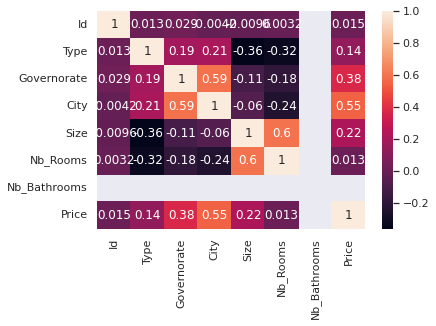

In [ ]:
sns.heatmap(filtered_df.corr(),annot=True)

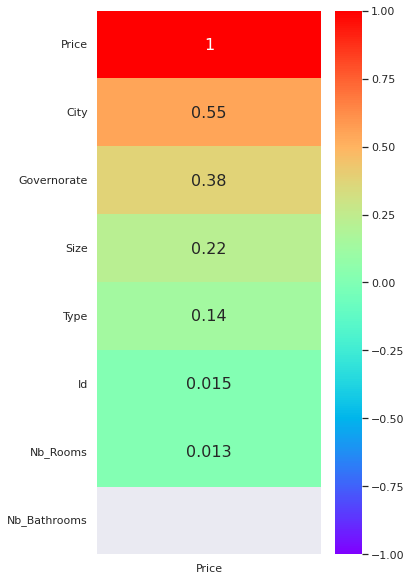

In [ ]:
top_features = filtered_df.corr()[['Price']].sort_values(by=['Price'],ascending=False).head(30)
plt.figure(figsize=(5,10))
sns.heatmap(top_features,cmap='rainbow',annot=True,annot_kws={"size": 16},vmin=-1)

In [ ]:
feature_sel_model = SelectFromModel(Lasso(alpha=0.005, random_state=101)) # remember to set the seed, the random state in this function
feature_sel_model.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=101))

In [ ]:
feature_sel_model.get_support()

array([ True,  True,  True,  True,  True, False])

In [ ]:
# let's print the number of total and selected features

# this is how we can make a list of the selected features
selected_feat = X_train.columns[(feature_sel_model.get_support())]

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
#print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)))

total features: 6
selected features: 5


In [ ]:
selected_feat

Index(['Type', 'Governorate', 'City', 'Size', 'Nb_Rooms'], dtype='object')

In [ ]:
X_train=X_train[selected_feat]
X_test=X_test[selected_feat]

In [ ]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)

In [ ]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import sklearn.gaussian_process as gp
from sklearn.model_selection import cross_val_score, cross_val_predict


In [ ]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

In [ ]:
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

GaussianProcessRegressor(alpha=0.1, kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10, normalize_y=True)
  Train R2 =  0.837
  Train RMSE =  1.021E+02
  Train MAPE =  0.097


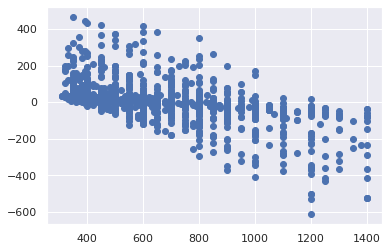

In [ ]:
model.fit(X1_train, y1_train)
# Model predictions on the trained data
y_train_pred = model.predict(X1_train)
# Model evaluations on the training data
print(model)
print('  Train R2 = ', '%.3f' %r2_score(y1_train, y_train_pred))
print('  Train RMSE = ', '%.3E' %np.sqrt(mean_squared_error(y1_train,y_train_pred)))
print('  Train MAPE = ', '%.3f' %mean_absolute_percentage_error(y1_train,y_train_pred))
# Residuals plot
plt.scatter(y1_train, y_train_pred-y1_train)
params = model.kernel_.get_params()

In [ ]:
y_predicted = model.predict(X1_test)

print(model)
print('  Test R2 = ', '%.3f' %r2_score(y1_test, y_predicted))
print('  Test RMSE = ', '%.3E' %np.sqrt(mean_squared_error(y1_test,y_predicted)))
print('  Test MAPE = ', '%.3f' %mean_absolute_percentage_error(y1_test,y_predicted))

GaussianProcessRegressor(alpha=0.1, kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10, normalize_y=True)
  Test R2 =  0.207
  Test RMSE =  2.294E+02
  Test MAPE =  0.300


In [ ]:
scores = cross_val_score(model, X1_train, y1_train, cv=10, scoring='r2').mean()*100
print ("Cross-validated scores de GPR:", scores)

Cross-validated scores de ARDRegression: 17.36818853848859


In [ ]:
y1_test_pred = model.predict(X1_test)

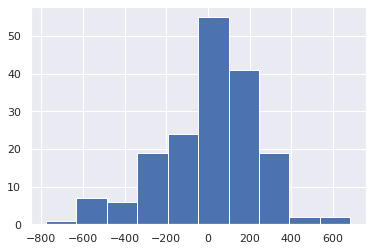


95.0 confidence interval -528.4007579717777 and 347.4893137153186


In [ ]:
plt.hist(y1_test_pred-y1_test)
plt.show()
 
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  np.percentile(y1_test_pred-y1_test, p)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  np.percentile(y1_test_pred-y1_test, p)
 
print(f"\n{alpha*100} confidence interval {lower} and {upper}")